# Simple BoW + Logistic Regression model

In this notebook we use the simplest approach: build Bag of Words features, and use them to train a Logistic Regression model. Everything is done in Scikit-Learn.

Our dataset is made of IMDB movie reviews, and our target is binary, whether the movie review is positive or negative.

Note that the main goal of this project is to showcase development and deployment practices within Watson Studio Local / Watson ML. Therefore, we did not spend much time fine tuning the model or trying different approaches.

In [40]:
# add scripts/ folder to path
import os, sys

SCRIPTS_PATH = os.environ['DSX_PROJECT_DIR'] + '/scripts'
sys.path.insert(0, SCRIPTS_PATH)

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import visualization # custom script

In [3]:
DATASET_PATH = "/user-home/libraries/text-analytics/datasets/aclImdb-small"
TRAIN_PATH = DATASET_PATH + "/train/"
TEST_PATH = DATASET_PATH + "/test/"

## 0. Load files

In [4]:
from sklearn.datasets import load_files

In [35]:
reviews_train = load_files(TRAIN_PATH)

In [36]:
# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[6]:\n{}".format(text_train[6]))

type of text_train: <class 'list'>
length of text_train: 2000
text_train[6]:
b"When I first saw this movie I was with my dad. He encouraged me to watch this movie because it was one of his favorites. After watching the movie it instantly became one of my favorites. <br /><br />A River Runs Through It is about two brothers who each take a different path in life. Norman Maclean (Craig Sheffer) is the older of the two brothers and he is set on the path of education. Paul Maclean (Brad Pitt) is the rebellious younger brother who travels on a path full of obstacles. The movie follows these characters as the each follow their own path.<br /><br />There is no downside to this movie. You will be entertained the whole way through. The acting, directing, and script is all perfect. The two things that are exceptional are the cinematography and the score. Both of which entrap you in the world Robert Redford creates for you. <br /><br />This is an all around great movie that is destined to be a cla

In [37]:
reviews_test = load_files(TEST_PATH)

In [38]:
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: {}".format(len(text_test)))
print("Samples per class (test): {}".format(np.bincount(y_test)))

Number of documents in test data: 2000
Samples per class (test): [1000 1000]


## 1. Preprocessing

Even though the preprocessing is short and straightforward, we probably want to move this to a script at some point.

In [39]:
text_train = [doc.replace(b"<br />", b" ").decode('utf-8') for doc in text_train]
text_test = [doc.replace(b"<br />", b" ").decode('utf-8') for doc in text_test]

In [10]:
text_train = pd.DataFrame({"review": text_train})
text_test = pd.DataFrame({"review": text_test})

In [11]:
np.unique(y_train)

array([0, 1])

In [12]:
print("Samples per class (training): {}".format(np.bincount(y_train)))

Samples per class (training): [1000 1000]


## 2. Feature Engineering

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

Note: We do this to understand the use of the vectorizer. We need to include the vectorizer in a pipeline in section 3. and retrain it there, so that the scoring endpoint includes the vectorizer itself (so we can pass text directly when calling the endpoint).

In [14]:
vect = CountVectorizer().fit(text_train.review)
X_train = vect.transform(text_train.review)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<2000x23032 sparse matrix of type '<class 'numpy.int64'>'
	with 272320 stored elements in Compressed Sparse Row format>


In [15]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 23032
First 20 features:
['00', '000', '000s', '007', '0079', '0080', '0083', '00pm', '00s', '01', '02', '06', '08', '09', '0s', '10', '100', '1000', '10000000000000', '101']
Features 20010 to 20030:
['survivors', 'susan', 'susannah', 'susceptible', 'suspect', 'suspected', 'suspects', 'suspend', 'suspended', 'suspending', 'suspends', 'suspense', 'suspenseful', 'suspension', 'suspicion', 'suspicions', 'suspicious', 'suspiciously', 'sustain', 'sustained']
Every 2000th feature:
['00', 'bedding', 'coddling', 'disqualify', 'floriane', 'hun', 'liu', 'obligingly', 'puppet', 'selflessness', 'surroundings', 'viewable']


## 3. Build model

### 3.1 Simple LogisticRegression, not tuned

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer

**Important note: The FunctionTransformer trick**

The CountVectorizer need to take an iterable over text as input. Yet, when we deploy our model, the endpoint will wrap the data that we send in a DataFrame, and the CountVectorizer won't be able to process it correctly. Therefore, we make sure to add as a first step of the pipeline a function that takes as input a pandas dataframe and selects the column "review".

To do that, we use the DataFrame's method .get(), instead of using for example a lambda function (e.g. *lambda x: x['review']*). The reason for that is that for model persistence, scikit-learn uses either pickle or joblib, and in both cases, any user-defined function that is called within a pipeline will fail when the model is loaded in another environment: In other words, you should always use methods that are either from the sklearn package or from any package that comes pre-installed, as specified [in the docs](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/pm_service_supported_frameworks.html)

In [17]:
pipe = make_pipeline(FunctionTransformer(pd.DataFrame.get, kw_args={'key':'review'}, validate=False), CountVectorizer(), LogisticRegression())
scores = cross_val_score(pipe, text_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.87


In [18]:
pipe.fit(text_train, y_train)

Pipeline(memory=None,
     steps=[('functiontransformer', FunctionTransformer(accept_sparse=False,
          func=<function NDFrame.get at 0x7f927d839a60>, inv_kw_args=None,
          inverse_func=None, kw_args={'key': 'review'},
          pass_y='deprecated', validate=False)), ('countvectorizer', CountVectorizer(analyzer='wo...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

### 3.2 Grid Search for Logistic Regression

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.87
Best parameters:  {'logisticregression__C': 1}


In [21]:
print("Test score: {:.2f}".format(grid.score(text_test, y_test)))

Test score: 0.82


In [22]:
model = grid.best_estimator_

### 3.3 Investigating model coefficients

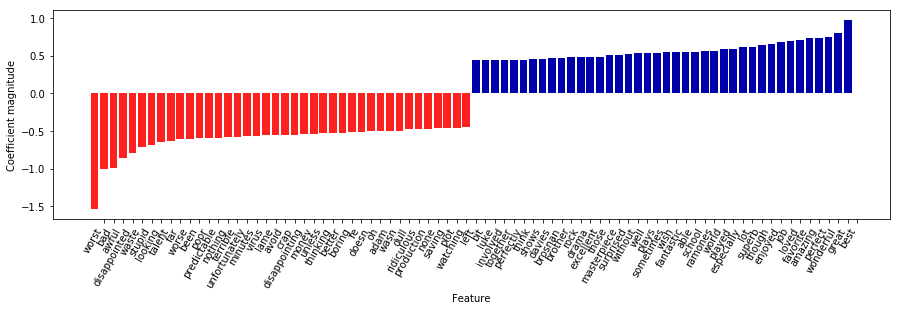

In [23]:
visualization.visualize_coefficients(
    model.steps[-1][1].coef_,
    feature_names, n_top_features=40)

## 4. Store model

### 4.1 Save model in ML repository

In [24]:
from dsx_ml.ml import save

In [25]:
deployment_info = save(name='simple-bow',
                        model=pipe,
                        x_test=text_test, # can't use that if doing option 2
                        y_test=pd.DataFrame({"pos": y_test}),
                        algorithm_type='Classification',
                        description='This is the first simple bag of words model with logistic regression.',
                        source='simple-bow.ipynb')
print(deployment_info)

Using TensorFlow backend.


{'path': '/user-home/1055/DSX_Projects/text-deployment-demo/models/simple-bow/2', 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python35/scikit-learn-0.19/text-deployment-demo/simple-bow/2'}


**Useful note**: The very first version we pushed was simple-bow, that used a sparse matrix representing bag-of-words features as its input. In a second iteration, we created a pipeline and put the vectorization part inside this pipeline so that the model now takes raw text as input. As a result, we can't just save the model as a new version after this iteration (simple-bow v2), we need to save it as a different model (simple-bow-pipe): this happens whenever you **change the number of features** or **change the feature names**, or **use a different version of your ML framework**.

Once this is called, the model shows up in the *"Models"* section of WSL, in version v1.

### 4.2 Test model in Models UI

- Save the notebook and switch to the Models tab of the project.
- Under Models, find and click into your saved model.
- Click the Real-time score link to test the model.

### 4.3 Test model with REST API call

In [26]:
import requests

In [27]:
json_payload = [{
    "review": "Awesome movie"
}]

In [28]:
header_online = {'Content-Type': 'application/json', 'Authorization': os.environ['DSX_TOKEN']}

response_scoring = requests.post(deployment_info['scoring_endpoint'], json=json_payload, headers=header_online)

In [29]:
prediction = response_scoring.json()['object']['output']['predictions'][0]
print ('Prediction = {}'.format(prediction))
probabilities = response_scoring.json()['object']['output']['probabilities'][0]
print ('Probabilities = {}'.format(probabilities))

Prediction = 1
Probabilities = [0.4097536610984577, 0.5902463389015423]


## 5. Evaluation

### 5.1 Automatically, when model is saved

Since we submitted the test dataframe when saving the model, the model will be automatically evaluated for each version we save and the result will appear on the "Accurcy History" chart of the model.

<img style="float: left;" src="https://i.imgur.com/TD6lz0d.png" alt="Step 3 - Modify custom script: switch to transform()" width=900 />

### 5.2 Generate evaluation script

First, we export the test dataset as a csv file in the '/datasets' folder:

In [49]:
pd.DataFrame({'review': text_test, 'pos': y_test}).to_csv("../datasets/test.csv")

We can now go to the Evaluation section of the model, in the UI, and generate a script that uses this dataset. There, we choose the evaluation metric that we are interested in as well as the threshold for which we consider the model to be good enough. We can choose to run it once, or schedule it so it is run periodically.

<img style="float: left;" src="https://i.imgur.com/yXM31Tg.png" alt="Step 3 - Modify custom script: switch to transform()" width=900 />